<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/naampy_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab/naampy/

/content/drive/MyDrive/Colab/naampy


In [2]:
%ls

data/  data.ipynb  model.h5  train.ipynb


In [125]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

# Import data

In [44]:
df = pd.read_csv('data/naampy_final.csv')

In [45]:
df.head()

,first_name,gender
0,aa,male
1,aaa,male
2,aaaa,female
3,aaaamsoo,female
4,aaaan,male


In [46]:
df['gender_codes'] = df.gender.astype('category').cat.codes

In [47]:
df.head()

,first_name,gender,gender_codes
0,aa,male,1
1,aaa,male,1
2,aaaa,female,0
3,aaaamsoo,female,0
4,aaaan,male,1


In [48]:
classes = df.groupby('gender').count().index

In [49]:
classes

Index(['female', 'male'], dtype='object', name='gender')

In [50]:
df.groupby('gender').count()

,first_name,gender_codes
gender,,
female,102461,102461
male,94882,94882


In [51]:
df.shape

(197343, 3)

# Split data

In [52]:
X = df['first_name'].values
y = df['gender_codes'].values

In [53]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [54]:
X_train.size

138140

In [55]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int8), array([71602, 66538]))

In [56]:
X_rem.size

59203

In [57]:
np.unique(y_rem, return_counts=True)

(array([0, 1], dtype=int8), array([30859, 28344]))

In [58]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [59]:
y_train = to_categorical(y_train, len(classes))
y_val = to_categorical(y_val, len(classes))
y_test = to_categorical(y_test, len(classes))

In [60]:
y_train[1]

array([0., 1.], dtype=float32)

In [61]:
X_train[1]

'krishnanaraayan'

# Tokenization

In [62]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

In [63]:
tk.fit_on_texts(df['first_name'].values)

In [64]:
alphabet="abcdefghijklmnopqrstuvwxyz"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

In [65]:
char_dict

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [66]:
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy() 
# Add 'UNK' to the vocabulary 
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [67]:
tk.word_index

{'UNK': 27,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [68]:
df['first_name'].str.len().max()

24

In [69]:
train_sequences = tk.texts_to_sequences(X_train)

In [71]:
train_sequences[0]

[19, 1, 22, 1, 12]

In [72]:
X_train[0]

'saval'

In [73]:
validation_sequences = tk.texts_to_sequences(X_val)
test_sequences = tk.texts_to_sequences(X_test)

In [75]:
# Padding
X_train = pad_sequences(train_sequences, maxlen=24, padding='post')
X_val = pad_sequences(validation_sequences, maxlen=24, padding='post')
X_test = pad_sequences(test_sequences, maxlen=24, padding='post')

In [76]:
X_train[0]

array([19,  1, 22,  1, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

# Creating Dataset

In [77]:
BATCH_SIZE = 64
BUFFER_SIZE = 200000

In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [79]:
text_batch, label_batch = next(iter(train_dataset))
first_name, gender_label = text_batch[0], label_batch[0]
print("Name", first_name)
print("Label", gender_label)

Name tf.Tensor([ 2 21  4  8  1  1  4  5 22  5  5  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(24,), dtype=int32)
Label tf.Tensor([1. 0.], shape=(2,), dtype=float32)


# Vectorization

In [81]:
vocab_size = len(tk.word_index)
vocab_size

27

In [82]:
embedding_weights = [] 
embedding_weights.append(np.zeros(vocab_size)) # first row is pad

for char, i in tk.word_index.items(): 
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

In [84]:
print(embedding_weights.shape) # first row all 0 for PAD, 26 char, last row for UNK
embedding_weights

(28, 27)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [116]:
# max length of first name 
input_size = 24
# vocab_size = 27
embedding_size = 27
conv_layers = [[256, 7, 3], 
               [256, 3, -1], 
               [256, 3, -1]]

fully_connected_layers = [1024, 1024]
num_of_classes = len(classes)
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [117]:
# Embedding layer Initialization
embedding_layer = tf.keras.layers.Embedding(vocab_size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Model

In [118]:
# Input
inputs = tf.keras.layers.Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 24)
# Embedding 
x = embedding_layer(inputs)


# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    print(filter_num, filter_size, pooling_size)
    x = tf.keras.layers.Conv1D(filter_num, filter_size)(x)
    x = tf.keras.layers.Activation('relu')(x)
    if pooling_size != -1:
        x = tf.keras.layers.MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
    print(x)
x = tf.keras.layers.Flatten()(x) # (None, 8704)
# Fully connected layers 
for dense_size in fully_connected_layers:
    x = tf.keras.layers.Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = tf.keras.layers.Dropout(dropout_p)(x)
# Output Layer
predictions = tf.keras.layers.Dense(num_of_classes, activation='softmax')(x)
# Build model
model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy
model.summary()

256 7 3
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 256), dtype=tf.float32, name=None), name='max_pooling1d_14/Squeeze:0', description="created by layer 'max_pooling1d_14'")
256 3 -1
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 256), dtype=tf.float32, name=None), name='activation_25/Relu:0', description="created by layer 'activation_25'")
256 3 -1
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 256), dtype=tf.float32, name=None), name='activation_26/Relu:0', description="created by layer 'activation_26'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 24)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 24, 27)            756       
                                                                 
 conv1d_32 (Conv1D)          (None, 18, 256)           48640     
  

In [119]:
model_save_filename = "model.h5"

In [120]:
batch_size = 64
epochs = 500

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    patience = 10,
    restore_best_weights = True
)

mdlcheckpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_save_filename,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True
)


In [121]:
history = model.fit(
    train_dataset,
    batch_size = batch_size,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/500
2158/2159 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.7879
Epoch 1: val_accuracy improved from -inf to 0.80815, saving model to model.h5
2159/2159 [==============================] - 24s 6ms/step - loss: 0.4516 - accuracy: 0.7879 - val_loss: 0.4150 - val_accuracy: 0.8081
Epoch 2/500
2150/2159 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8189
Epoch 2: val_accuracy improved from 0.80815 to 0.81565, saving model to model.h5
2159/2159 [==============================] - 11s 5ms/step - loss: 0.3975 - accuracy: 0.8188 - val_loss: 0.4026 - val_accuracy: 0.8156
Epoch 3/500
2153/2159 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8300
Epoch 3: val_accuracy improved from 0.81565 to 0.82392, saving model to model.h5
2159/2159 [==============================] - 11s 5ms/step - loss: 0.3743 - accuracy: 0.8300 - val_loss: 0.3826 - val_accuracy: 0.8239
Epoch 4/500
2148/2159 [============================>.] - ETA:

# Evaluate

In [123]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

463/463 [==============================] - 1s 3ms/step - loss: 0.3893 - accuracy: 0.8252
Loss:  0.38926002383232117
Accuracy:  0.82518070936203


# Plot

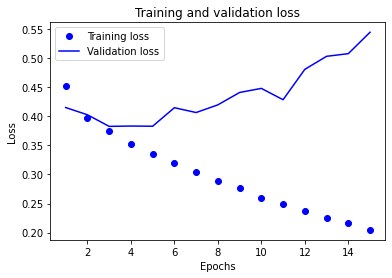

In [126]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

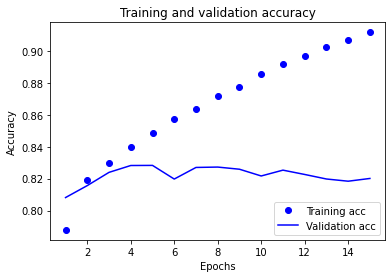

In [127]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Save model

In [129]:
model.save('saved_model/naampy')

INFO:tensorflow:Assets written to: saved_model/naampy/assets


# Inference

In [148]:
input = [
         "rajinikanth",
         "mahesh",
         "vikram",
         "kamal",
         "meena",
         "kareena",
         "uma"
]

sequences = tk.texts_to_sequences(input)
final = pad_sequences(sequences, maxlen=24, padding='post')
print(final)

[[18  1 10  9 14  9 11  1 14 20  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  1  8  5 19  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [22  9 11 18  1 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  1 13  1 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13  5  5 14  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11  1 18  5  5 14  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [21 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [149]:
results = model.predict(final)
probs = tf.nn.softmax(results)
res_args = tf.argmax(probs, 1)

In [150]:
probs

<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[0.27311411, 0.7268859 ],
       [0.26971525, 0.73028475],
       [0.29096594, 0.709034  ],
       [0.43837994, 0.56162006],
       [0.7167793 , 0.2832207 ],
       [0.6409049 , 0.35909516],
       [0.5948701 , 0.4051299 ]], dtype=float32)>

In [151]:
res_args

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([1, 1, 1, 1, 0, 0, 0])>

In [152]:
for i in range(len(input)):
  print(f"{input[i]} : {classes[res_args[i]]}")

rajinikanth : male
mahesh : male
vikram : male
kamal : male
meena : female
kareena : female
uma : female


In [158]:
model.get_layer('embedding_9').get_weights()[0].shape

(28, 27)

# load and test the model

In [159]:
import_model = tf.keras.models.load_model('saved_model/naampy')

In [160]:
import_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 24)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 24, 27)            756       
                                                                 
 conv1d_32 (Conv1D)          (None, 18, 256)           48640     
                                                                 
 activation_24 (Activation)  (None, 18, 256)           0         
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 6, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 4, 256)            196864    
                                                             

In [161]:
results = model.predict(final)
probs = tf.nn.softmax(results)
res_args = tf.argmax(probs, 1)
for i in range(len(input)):
  print(f"{input[i]} : {classes[res_args[i]]}")

rajinikanth : male
mahesh : male
vikram : male
kamal : male
meena : female
kareena : female
uma : female
